# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [45]:
# Constants for quicker Debugging
DEBUG_MODUS = True
LEARN_MODUS = True

DEVICE_NAME = "/gpu:0" #Alternative: "/cpu:0"

In [2]:
import cv2

In [3]:
import os
from scipy.misc import imresize

import random
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

import pandas as pd
from IPython.display import display, HTML

import itertools

In [4]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train.shape: {} \ny_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} \ny_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (39209, 32, 32, 3) 
y_train.shape: (39209,)
X_test.shape: (12630, 32, 32, 3) 
y_test.shape: (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.


# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.ptp() + 1 

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
sign_names=pd.read_csv('signnames.csv', sep=',')

if not DEBUG_MODUS:
    display(sign_names)

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def visualize_class(classId, num_images = 8):
    """Display a few signs of a single class
    Keyword arguments:
    classID    -- Class ID of the sign
    num_images -- Number of images shown
    """
    
    examples_train = X_train[np.where(y_train==classId)[0]]
    # pick random index
    idx = np.random.choice(len(examples_train), num_images)
    
    f, ax = plt.subplots(1, num_images, figsize=(16,3))
    f.suptitle("{} - {}.".format(classId, sign_names['SignName'][classId]), fontsize='xx-large')
    
    for i in range(num_images):     
        ax[i].imshow(examples_train[idx[i]])
        ax[i].axis('off')

    plt.show()

for c in range(n_classes):
    if not DEBUG_MODUS:
        visualize_class(c)

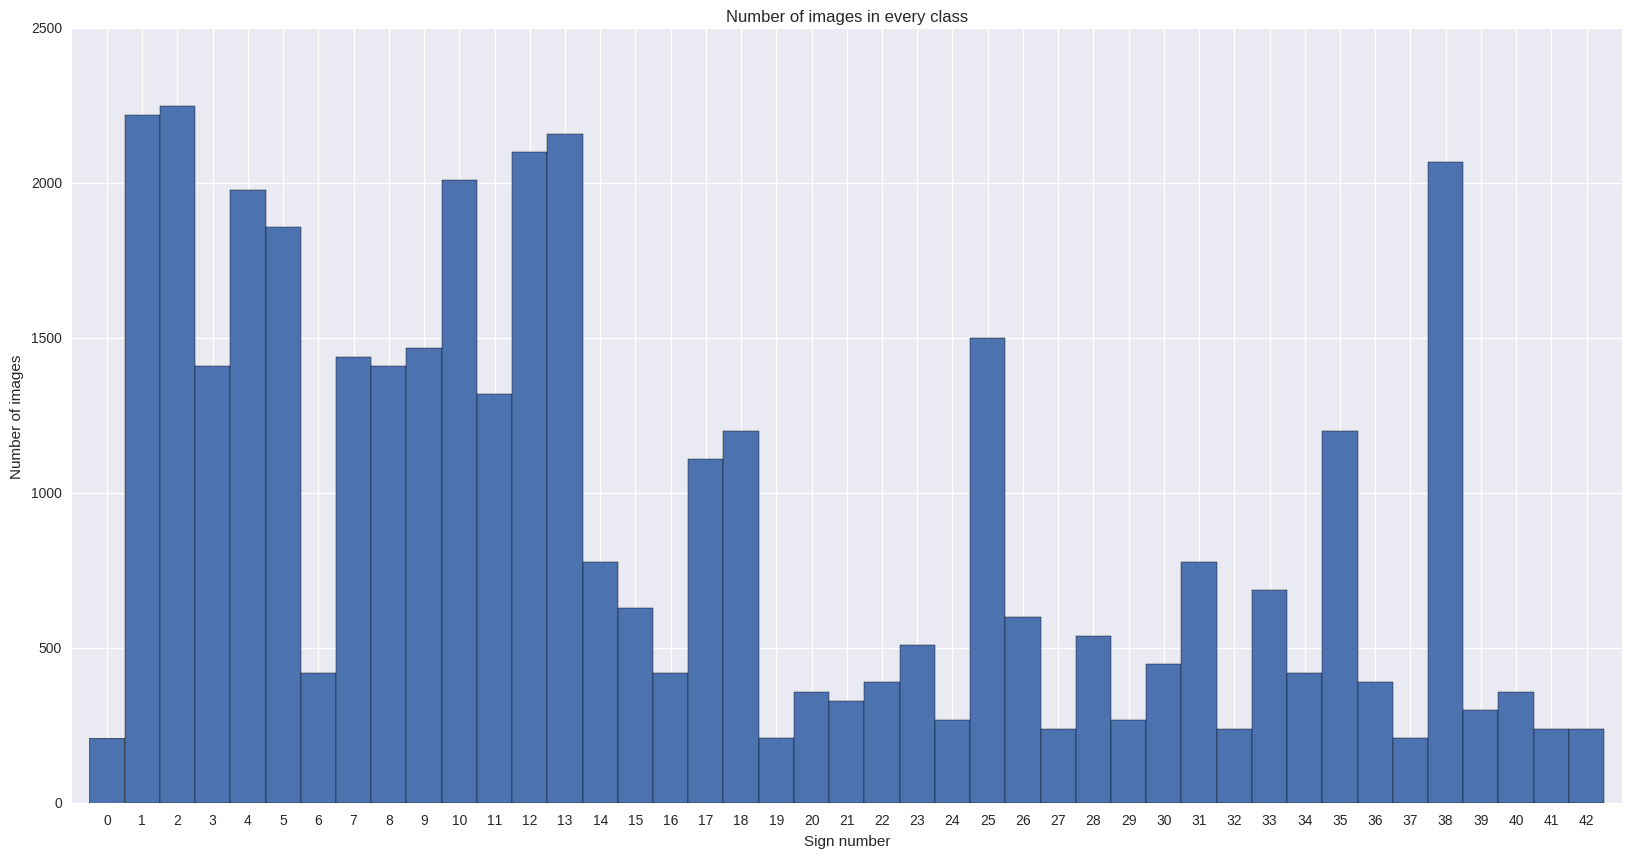

In [8]:
#Histogram of sign occurrences

plt.figure(figsize=(20,10))
plt.hist(y_train, np.arange(n_classes+1) - 0.5) #+1 and -0.5 is for centering labels
plt.xticks(range(n_classes))
plt.xlim([-1, n_classes])
plt.title("Number of images in every class")
plt.ylabel("Number of images")
plt.xlabel("Sign number")

plt.show()

The occurences of the signs are very unbalanced. A good approach would be to balance the data. One way would be to crop all amounts on the height of the lowest bar. Another way would be to generate new data (rotating, decrease or increase size).

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# 1) Data-Preparation

## 1.1 Investigation of Data

In [9]:
%matplotlib inline
from IPython.display import HTML

random.seed(datetime.now())

def plot_images(offset = 0, num_images = 5):
    """Plot signs from the offset."""
    print("Plot {} images from the offset {}".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset+i+(a*num_images)
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            
    plt.show()

def plot_random_train(offset = 0, num_images = 5):
    """Plot random signs."""
    print("Plot {} *random* images".format(num_images, offset))
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            offset = random.randint(0,len(X_train))
            
    plt.show()

if not DEBUG_MODUS:
    plot_images(offset=100)
    plot_random_train()

## 1.2 Find and display dark and bright images

In [10]:
is_features_normal = False
is_labels_encod = False

In [11]:
### Just a view other normalizing tests I wanted to keep
"""
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def normalize_grayscale(image_data):
    
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    
    
    a = 0.1
    b = 0.9
    x_max = image_data.max()
    x_min = image_data.min()
    return a + (((image_data-x_min)*(b-a))/(x_max-x_min))

    
def normalize(data):
    #return (data.astype('float32') / 127.5 - 0.5)
    return (data.astype('float32') / 255)
"""


"\ndef rgb2gray(rgb):\n    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])\n\ndef normalize_grayscale(image_data):\n    \n    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]\n    :param image_data: The image data to be normalized\n    :return: Normalized image data\n    \n    \n    a = 0.1\n    b = 0.9\n    x_max = image_data.max()\n    x_min = image_data.min()\n    return a + (((image_data-x_min)*(b-a))/(x_max-x_min))\n\n    \ndef normalize(data):\n    #return (data.astype('float32') / 127.5 - 0.5)\n    return (data.astype('float32') / 255)\n"

Dark images (before normalisation):


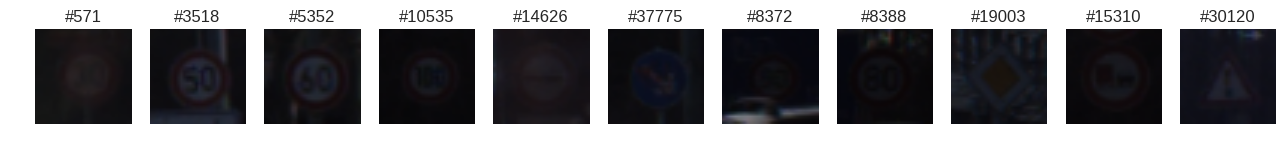

Bright images (before normalisation):


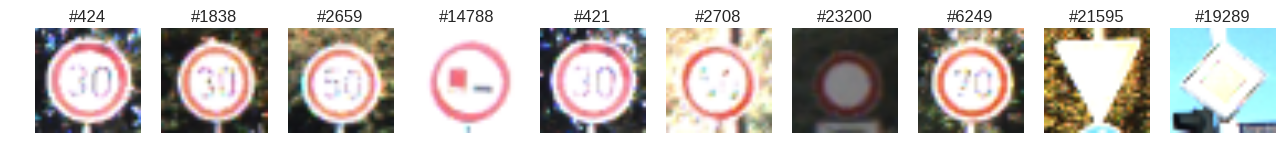

In [12]:
def plot_dark():
    """Plot dark Images"""
    dark = [571, 3518, 5352, 10535, 14626, 37775, 8372, 8388, 19003, 15310, 30120]

    f, ax = plt.subplots(1, len(dark), figsize=(16,3))

    for i, pic_id in enumerate(dark):
        ax[i].imshow(X_train[pic_id])
        ax[i].axis('off')
        ax[i].set_title("#{}".format(pic_id))

    plt.show()

def plot_bright():
    """Plot bright Images"""
    
    bright = [424, 1838, 2659, 14788, 421, 2708, 23200, 6249, 21595, 19289]

    f, ax = plt.subplots(1, len(bright), figsize=(16,3))

    for i, pic_id in enumerate(bright):
        ax[i].imshow(X_train[pic_id])
        ax[i].axis('off')
        ax[i].set_title("#{}".format(pic_id))
        
    plt.show()
    
print("Dark images (before normalisation):")
plot_dark()
print("Bright images (before normalisation):")
plot_bright()

## 1.3 Normalization

In [13]:
def normalize_YUV(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB) 

# data preperation: normalize
if not is_features_normal:       
    ## Normalize Training Set
    for i, pic in enumerate(X_train):
        X_train[i] = normalize_YUV(X_train[i])

    ## Normalize Test Set
    for i, pic in enumerate(X_test):
        X_test[i] = normalize_YUV(X_test[i])
    
    #Only normalize once
    is_features_normal = True

Dark images (after normalisation):


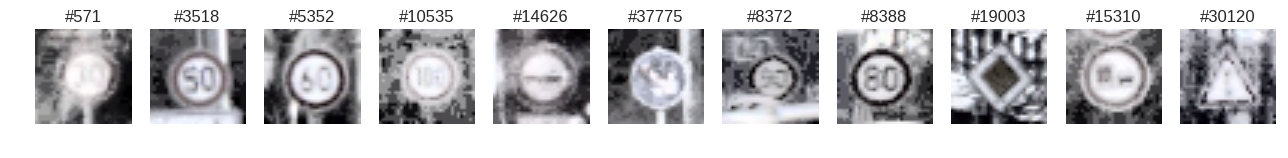

Bright images (after normalisation):


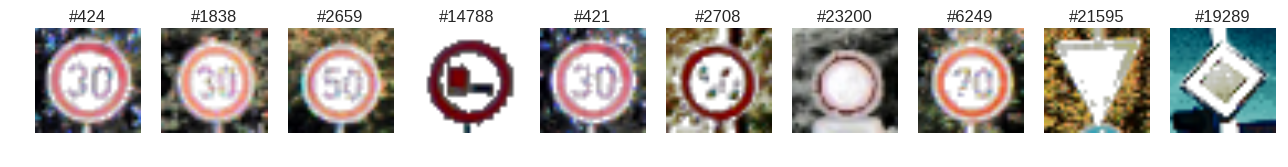

In [14]:
print("Dark images (after normalisation):")
plot_dark()
print("Bright images (after normalisation):")
plot_bright()

## 1.4 One Hot Encoding

In [15]:
# One Hot Encoding

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    #Only One Hot Encode once
    is_labels_encod = True

In [16]:
#Check if One-Hot Encoding works
print("y_train.shape: {}".format(y_train.shape))
for i in range(5):
    a=random.randint(0,n_train)
    print("index = {}\n{}".format(a, y_train[a]))
    
print("\n\ny_test.shape: {}".format(y_test.shape))
for i in range(5):
    a=random.randint(0,n_test)
    print("index = {}\n{}".format(a, y_test[a]))

y_train.shape: (39209, 43)
index = 12758
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 20170
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 13598
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 8375
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 31664
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


y_test.shape: (12630, 

In [17]:
# One Hot to Classnumber
y_test_classes = np.argmax(y_test,1)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 
I found a lot of very dark and bright images. I used histogram equalization, as described in the opencv doc: http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html
This had a very positive effect for the dark and bright pictures and made them more readable.

For the labels I used one hot encoding. 

## 2) Split in Train, Val and Test

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train )

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I divided the data set into Training, Validation and Testing data. I used 33% of the training data for validation.

In [19]:
print("Train size: \t\t{}\nValidiation size: \t{}\nTest size: \t\t{}".format(
        X_train.shape, X_val.shape, X_test.shape))

Train size: 		(26270, 32, 32, 3)
Validiation size: 	(12939, 32, 32, 3)
Test size: 		(12630, 32, 32, 3)


## 3) Convolutional Network

## 3.1 Define Architecure and Helper-functions

In [20]:
EPOCHS = 15
BATCH_SIZE = 50

In [21]:
def LeNet(x, keep_prob):

    # 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal([5, 5, 3, 6], stddev = 0.01))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16),stddev = 0.01))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')   

    # Flatten
    fc1 = flatten(conv2)
    # (5 * 5 * 16, 120)

    fc1_W = tf.Variable(tf.truncated_normal([400,120],stddev = 0.01))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes), stddev = 0.01))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc1, fc2_W) + fc2_b

In [47]:
with tf.device(DEVICE_NAME):
    # Data consists of 32x32x3 images
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))

    # Classify over 43 signs
    y = tf.placeholder(tf.float32, (None, n_classes))

    #Keep probability for Dropout
    keep_prob = tf.placeholder(tf.float32)

    #Call LeNet
    fc2 = LeNet(x, keep_prob)

    # Loss
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))

    # Optimizer: AdamOptimizer
    opt = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = opt.minimize(loss_op)

    correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
def eval_data(X_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        batch_y = y_data[batch_start:batch_end]
        
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        
    return total_loss/num_examples, total_acc/num_examples


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** I am using the LeNet Architecture from the lectures. I am using RELUs as activation function.

| Layer        | Size           | 
| ------------- |:-------------:| 
| Input     | 32x32x3 | 
| conv1:      | 28x28x6       |
| max_pool1:      | 14x14x6       |
| conv2 | 10x10x16      | 
| max_pool2 | 5x5x16      | 
| Flatten | 400x120     | 
| Fully_con1 | 400x120     | 
| Dropout | (keep_prob is 0.5)      | 
| Fully_con2 | 120x43      | 
| Output | 43      | 

## 3.2 Learning

In [24]:
#http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python

saver = tf.train.Saver()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

if __name__ == '__main__':
    if LEARN_MODUS:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            steps_per_epoch = len(X_train) // BATCH_SIZE
            num_examples = steps_per_epoch * BATCH_SIZE

            # Train model
            for i in range(EPOCHS):
                for step in range(steps_per_epoch):
                    batch_start = step * BATCH_SIZE
                    batch_end = (step + 1) * BATCH_SIZE
                    batch_x = X_train[batch_start:batch_end] 
                    batch_y = y_train[batch_start:batch_end]

                    loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

                train_loss, train_acc = eval_data(X_train, y_train)
                print("EPOCH {} ...".format(i+1))
                print("Training loss = {:.3f}".format(train_loss))
                print("Training accuracy = {:.3f}".format(train_acc))
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                
                val_loss, val_acc = eval_data(X_val, y_val)
                print("EPOCH {} ...".format(i+1))
                print("Validation loss = {:.3f}".format(val_loss))
                print("Validation accuracy = {:.3f}".format(val_acc))
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                
            saver.save(sess, 'foo')
            print("Model saved")
               

EPOCH 1 ...
Training loss = 0.859
Training accuracy = 0.718
EPOCH 1 ...
Validation loss = 0.873
Validation accuracy = 0.715
EPOCH 2 ...
Training loss = 0.516
Training accuracy = 0.843
EPOCH 2 ...
Validation loss = 0.540
Validation accuracy = 0.830
EPOCH 3 ...
Training loss = 0.361
Training accuracy = 0.891
EPOCH 3 ...
Validation loss = 0.388
Validation accuracy = 0.881
EPOCH 4 ...
Training loss = 0.298
Training accuracy = 0.907
EPOCH 4 ...
Validation loss = 0.337
Validation accuracy = 0.893
EPOCH 5 ...
Training loss = 0.246
Training accuracy = 0.925
EPOCH 5 ...
Validation loss = 0.291
Validation accuracy = 0.908
EPOCH 6 ...
Training loss = 0.251
Training accuracy = 0.924
EPOCH 6 ...
Validation loss = 0.300
Validation accuracy = 0.904
EPOCH 7 ...
Training loss = 0.217
Training accuracy = 0.933
EPOCH 7 ...
Validation loss = 0.265
Validation accuracy = 0.916
EPOCH 8 ...
Training loss = 0.179
Training accuracy = 0.947
EPOCH 8 ...
Validation loss = 0.228
Validation accuracy = 0.929
EPOCH 9 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


Optimizer AdamOptimizer with a learning_rate=0.001

EPOCHS = 10

BATCH_SIZE = 50


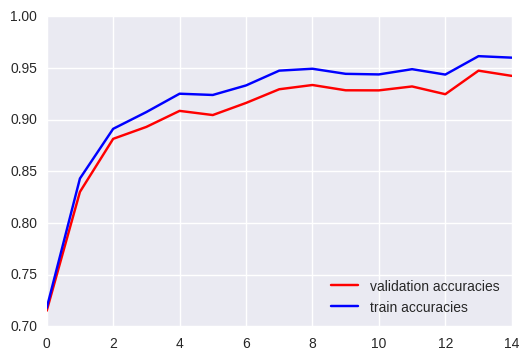

In [25]:
plt.plot(range(EPOCHS), val_accuracies, 'r-',
        range(EPOCHS), train_accuracies, 'b-')
        #range(EPOCHS), (list(np.array(val_accuracies) - np.array(train_accuracies))), 'g-')
#plt.plot(train_accuracies)
plt.legend(["validation accuracies", "train accuracies", "delta between val and train"],loc='lower right')
plt.show()

In [26]:
for i, a in enumerate(val_accuracies):
    print("{}: {:.4f}".format(i,a))

0: 0.7150
1: 0.8301
2: 0.8814
3: 0.8929
4: 0.9084
5: 0.9044
6: 0.9161
7: 0.9294
8: 0.9335
9: 0.9284
10: 0.9283
11: 0.9321
12: 0.9246
13: 0.9474
14: 0.9423


## 3.3 Evaluate on Test-Data

In [27]:
predicions = tf.argmax(fc2,1)
predicted_classes = []

#new_graph = tf.Graph()
#with tf.Session(graph=new_graph) as sess:

saver = tf.train.Saver()
#    with tf.Session() as sess:
#        saver.restore(sess, './vggsmall-20')


with tf.Session() as sess:   
    #sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('foo.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    #test_loss, test_acc = eval_data(X_test, y_test)
    #print("Test loss = {:.3f}".format(test_loss))
    #print("Test accuracy = {:.3f}".format(test_acc))

    predicted_classes = sess.run(predicions, feed_dict={x: X_test, keep_prob: 1.0})

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    if not normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 40  10   0 ...,   0   0   0]
 [  2 668  23 ...,   0   0   0]
 [  1  24 687 ...,   0   0   0]
 ..., 
 [  0   9   0 ...,  57   0   6]
 [  0   0   0 ...,   0  40   0]
 [  0   0   0 ...,   0   3  83]]
Confusion matrix, without normalization
[[ 40  10   0 ...,   0   0   0]
 [  2 668  23 ...,   0   0   0]
 [  1  24 687 ...,   0   0   0]
 ..., 
 [  0   9   0 ...,  57   0   6]
 [  0   0   0 ...,   0  40   0]
 [  0   0   0 ...,   0   3  83]]


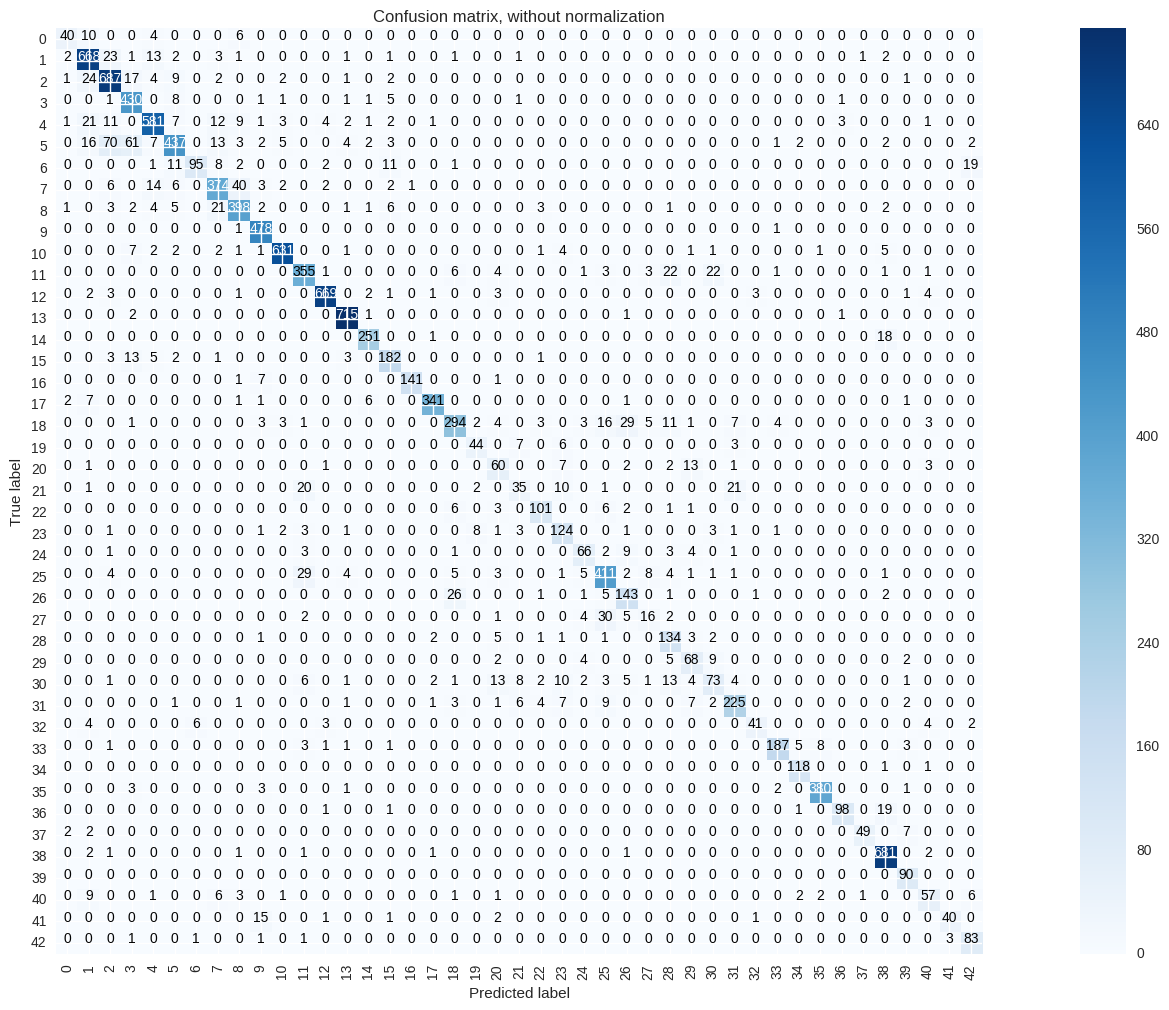

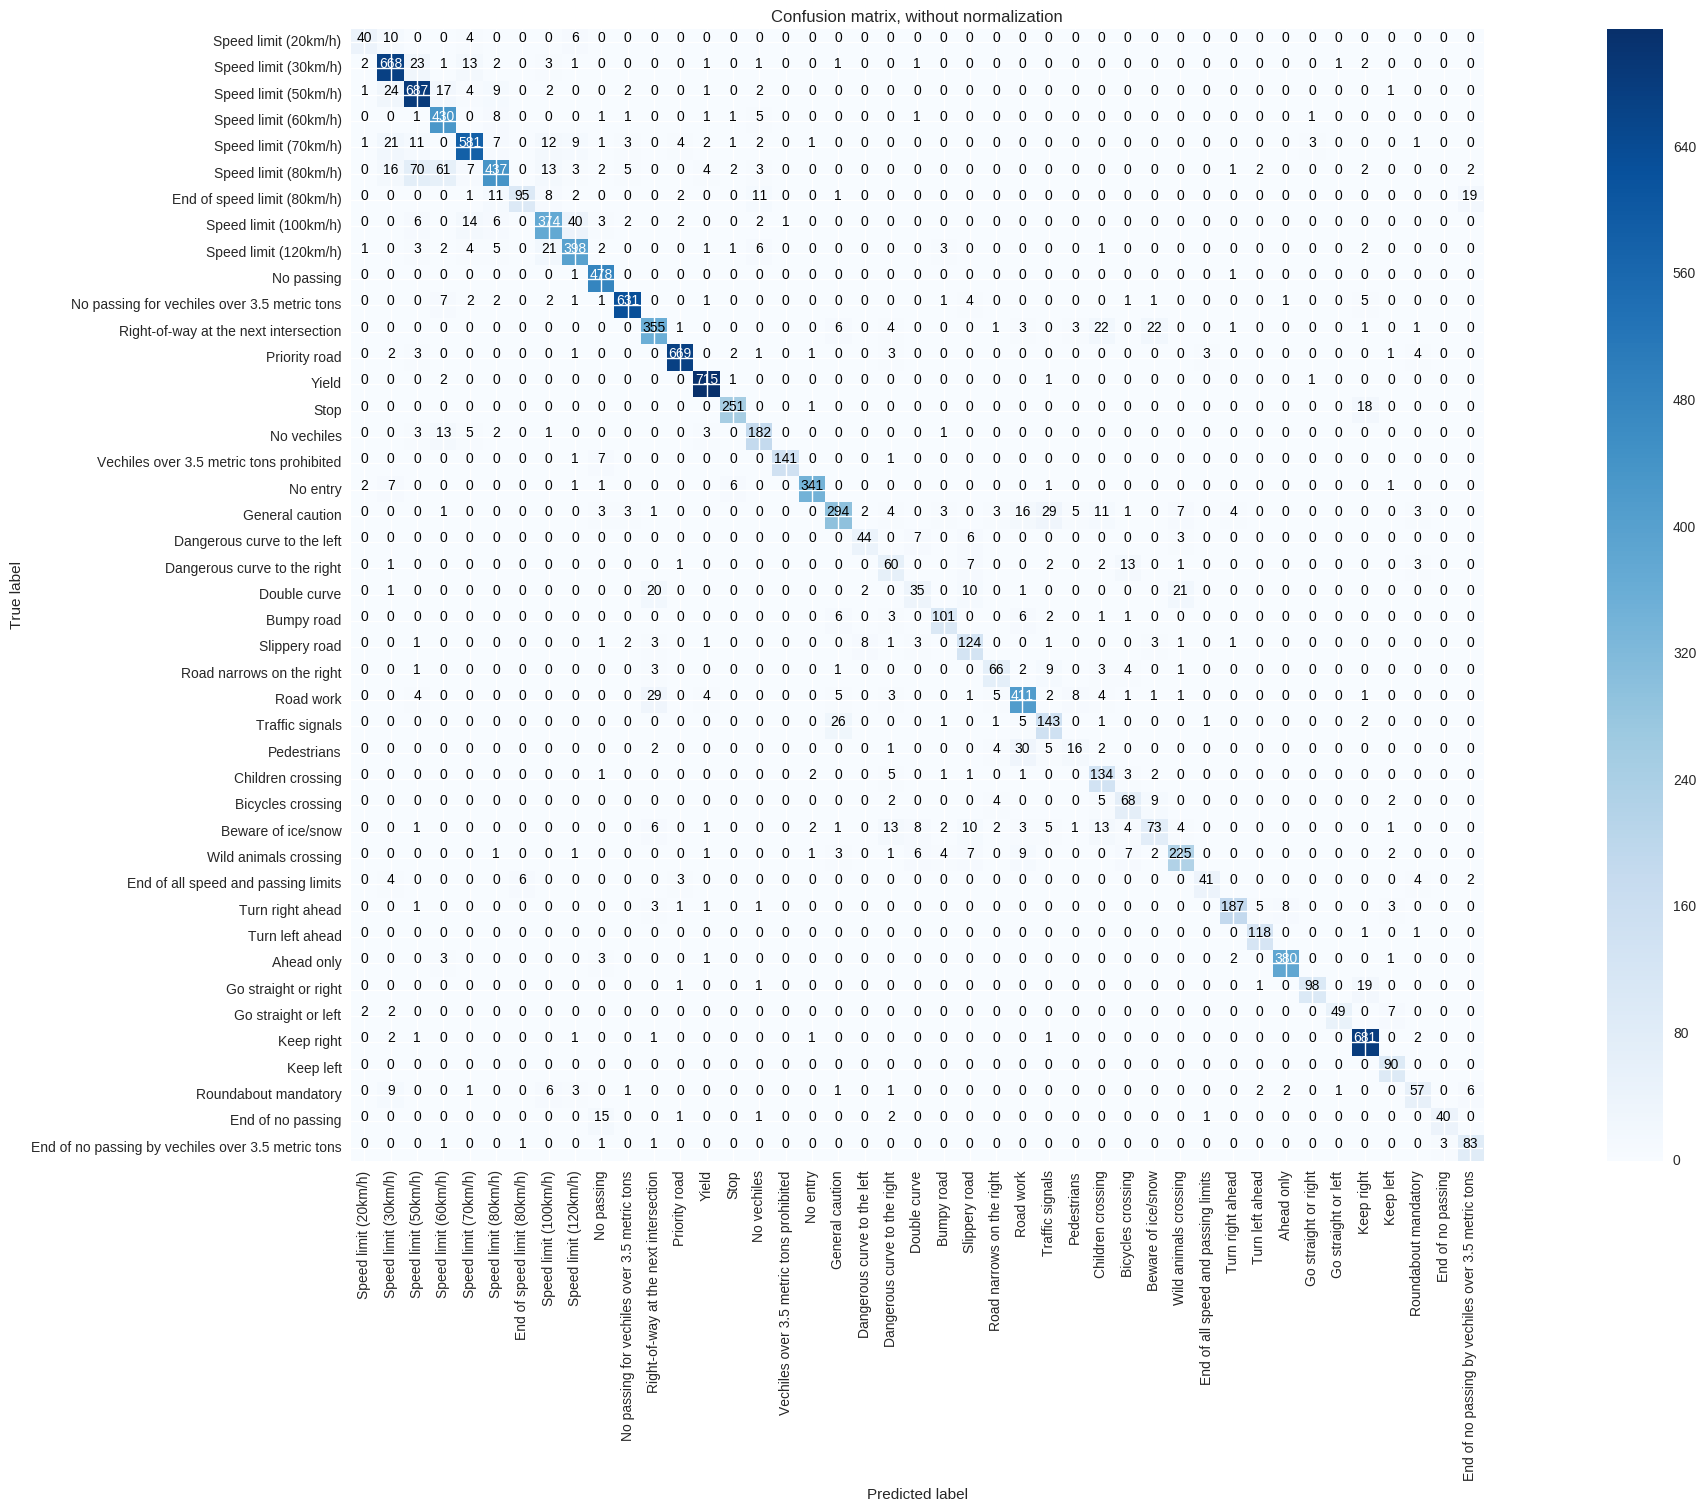

In [29]:
# Create Confusion Matrix
cnf_matrix = confusion_matrix(y_test_classes, predicted_classes)

# Plot Confusion Matrix
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))

#Plot with Number
plot_confusion_matrix(cnf_matrix,classes=range(43),
                      title='Confusion matrix, without normalization')

#Plot with Sign Names
plt.figure(figsize=(25,15))
plot_confusion_matrix(cnf_matrix,classes=sign_names['SignName'],
                      title='Confusion matrix, without normalization')

plt.show()

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** My process contained a trial and error phase, I tried different things and made my decision based on the results.

**First try:** 

EPOCH 10 ...
Test loss = 0.892
Test accuracy = 0.811

<br><br><br>
**Test#1 Changed Normalisation to -1 to +1**

EPOCH 10 ...
Validation loss = 0.121
Validation accuracy = 0.967

EPOCH 10 ...
Test loss = 0.867
Test accuracy = 0.877

**DECISION: Change Normalisation to -1 to +1**

<br><br><br>
**Test#2 Try grayscale**

EPOCH 10 ...
Validation loss = 0.353
Validation accuracy = 0.899
EPOCH 10 ...
Test loss = 1.212
Test accuracy = 0.796

**DECISION: Discard grayscale and stick to color**

<br><br><br>
**Test#3 Try Normalisation with OpenCV-histogram_equalization http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html**

EPOCH 10 ...
Validation loss = 0.147
Validation accuracy = 0.969
EPOCH 10 ...
Test loss = 0.699
Test accuracy = 0.886

**DECISION: Better results! I will stick to this normalisation**

<br><br><br>
**Test#4 Try Dropout with keep_prob=0.5**

EPOCH 10 ...
Validation loss = 0.181
Validation accuracy = 0.947
EPOCH 10 ...
Test loss = 0.468
Test accuracy = 0.888

**DECISION: Not really that much better... However I will stick to it, because it will reduce Overfitting**

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [31]:
index_five = [142, 1542, 2842, 3024, 4442]
test_five = X_test[index_five]
sess = tf.Session()

predicted_classes = []

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
       
    predicted_classes = sess.run(predicions, feed_dict={x: test_five, keep_prob: 1.0})

[]

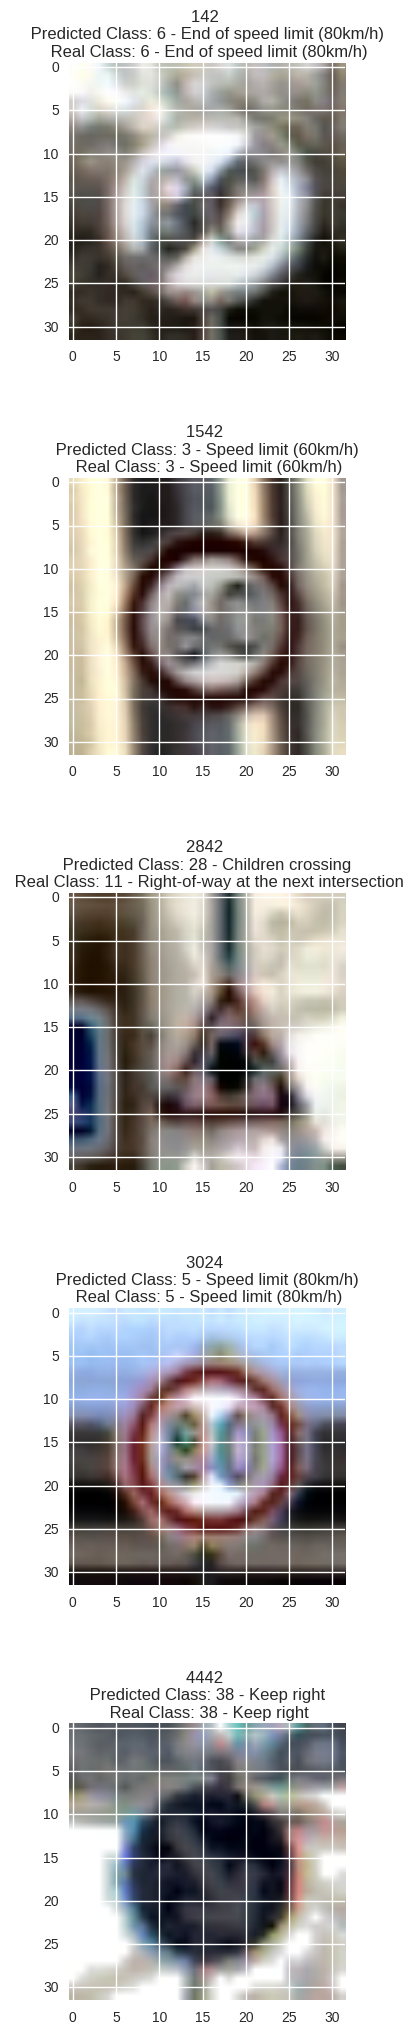

In [32]:
f, ax = plt.subplots(len(index_five), 1, figsize=(12.0, 25.0))
f.subplots_adjust(hspace=.5)
for i, idx in enumerate(index_five):    
    #Plot Image
    ax[i].imshow(X_test[idx])
    #print("Index: {}".format(index_five[i]))
    #print("Predicted: {}".format(predicted_classes[i]))
    #print("Predicted ausgeschrieben: {}".format(sign_names['SignName'][predicted_classes[i]]))
    #print("Echt: {}".format(y_test_classes[idx]))
    #print("Echt ausgeschrieben: {}".format(sign_names['SignName'][y_test_classes[idx]]))
    #ax[i].set_title("#{} \nReal Class: \{}".format(, "original size"))
    ax[i].set_title("{} \n Predicted Class: {} - {} \n Real Class: {} - {}".format(index_five[i], predicted_classes[i], sign_names['SignName'][predicted_classes[i]], y_test_classes[idx], sign_names['SignName'][y_test_classes[idx]]))
 
 
plt.plot()


In [33]:
index_five

[142, 1542, 2842, 3024, 4442]

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

[]

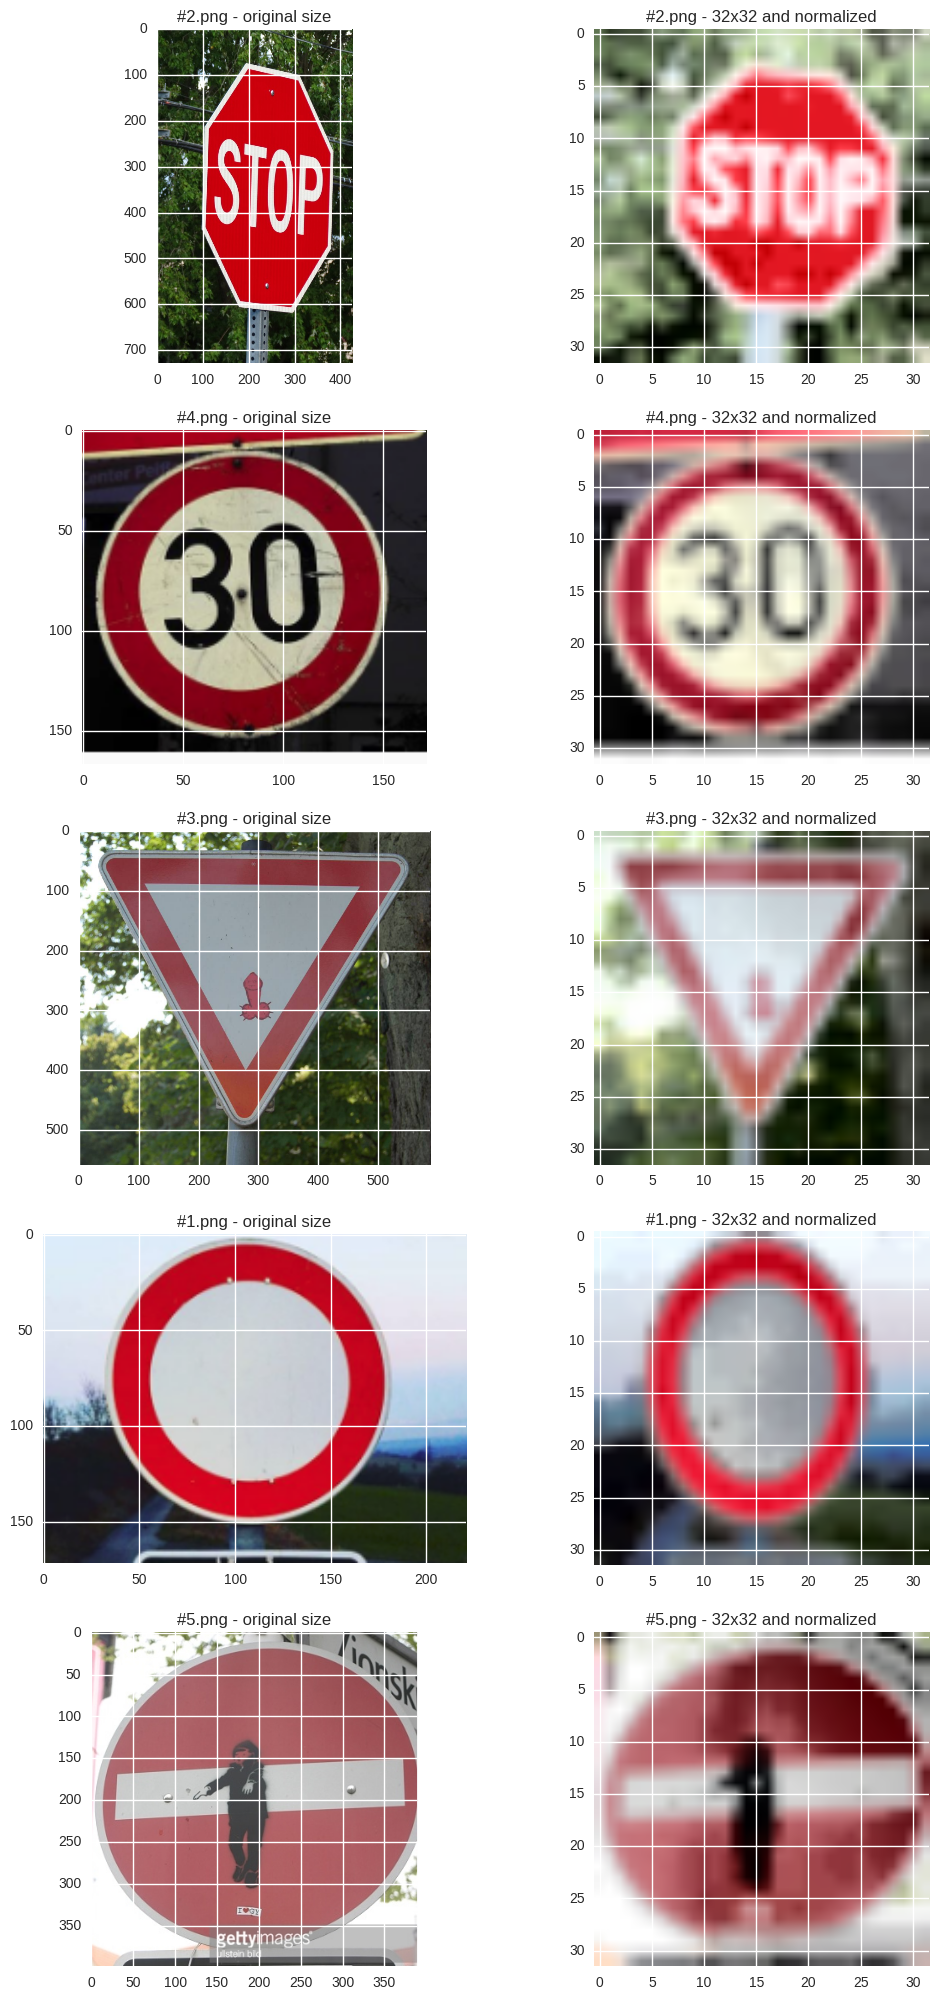

In [34]:
# Load Internet Signs
path = 'internet_signs/'

num_images = len(os.listdir(path))
f, ax = plt.subplots(num_images, 2, figsize=(12.0, 25.0))
arrays = [np.zeros(shape=(32,32,3)) for _ in range(num_images)]
inet_signs = np.stack(arrays, axis=0)


for i, filename in enumerate(os.listdir(path)):    
    #Load Image from file
    img = plt.imread(path+filename)
    
    #Resize to 32x32
    out_32 = imresize(img, [32,32])
    
    #Normalize
    out_32 = normalize_YUV(out_32)
    
    #Save in Numpy Array
    inet_signs[i] = out_32
    
    #Plot original Image
    ax[i][0].imshow(img)
    ax[i][0].set_title("#{} - {}".format(filename, "original size"))
    
    #Plot 32x32 normalized Image
    ax[i][1].imshow(out_32)
    ax[i][1].set_title("#{} - {}".format(filename, "32x32 and normalized"))
 
plt.plot()


In [35]:
sess = tf.Session()

predicted_classes = []

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
       
    predicted_classes = sess.run(predicions, feed_dict={x: inet_signs, keep_prob: 1.0})

In [36]:
inet_real_y = [0,0,0,0,0]
inet_real_y[0] = 14
inet_real_y[1] = 1
inet_real_y[2] = 13
inet_real_y[3] = 15
inet_real_y[4] = 17

[]

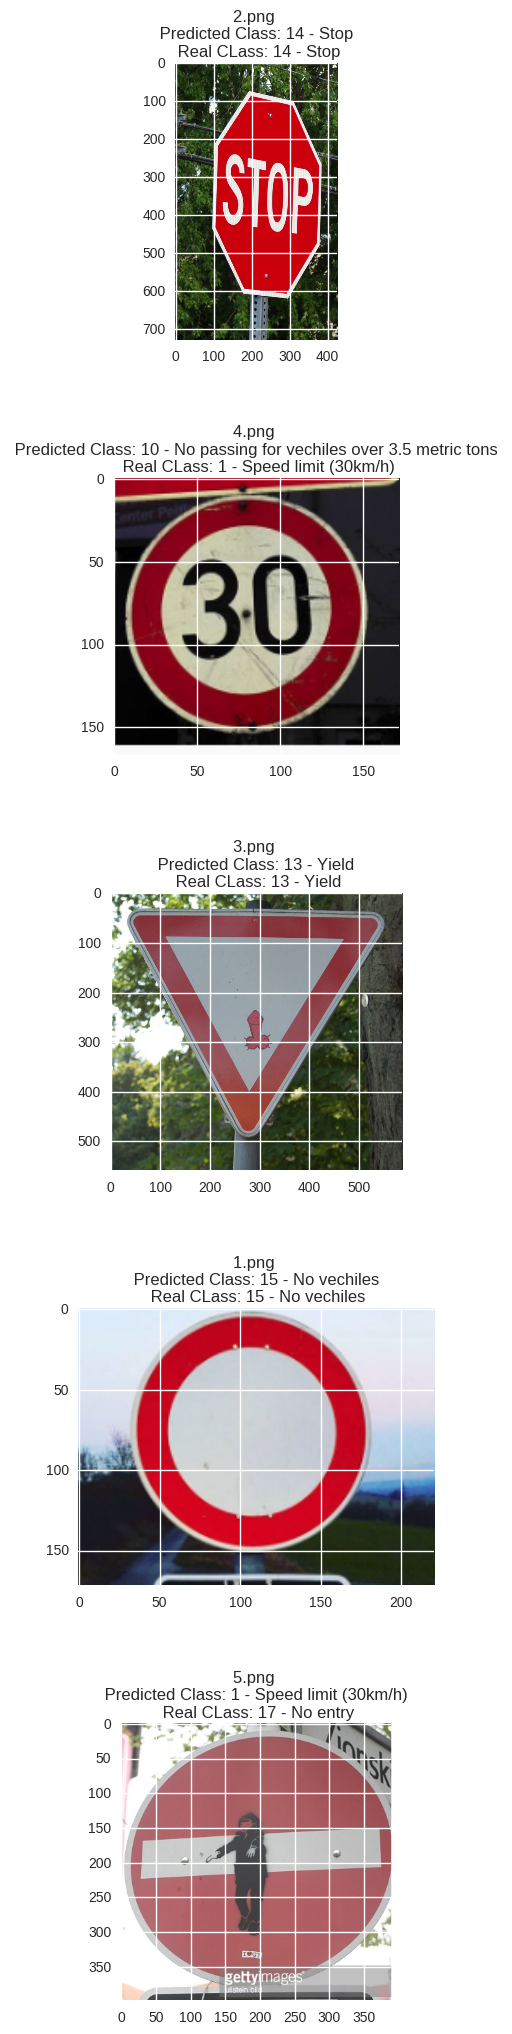

In [37]:
f, ax = plt.subplots(num_images, 1, figsize=(12.0, 25.0))
#f.suptitle("{} - {}.".format(classId, sign_names['SignName'][classId]), fontsize='x-large') 
f.subplots_adjust(hspace=.5)
for i, filename in enumerate(os.listdir(path)):    
    #Load Image from file
    img = plt.imread(path+filename)
    
    #Plot original Image
    ax[i].imshow(img)
    ax[i].set_title("{} \n Predicted Class: {} - {} \n Real CLass: {} - {}".format(
            filename, predicted_classes[i], sign_names['SignName'][predicted_classes[i]], 
            inet_real_y[i], sign_names['SignName'][inet_real_y[i]]))
 
plt.plot()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

4 out of 5 pictures from the internet were correctly classified

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [38]:
%precision 2
sess = tf.Session()

predicted_classes = []
probabilities = tf.nn.softmax(fc2)

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    #logits = model(x, keep_prob)
    
    top_k = tf.nn.top_k(probabilities, 3)
       
    probs, nn = sess.run([probabilities, top_k], feed_dict={x: inet_signs, keep_prob: 1.0})
    #predicted_classes = sess.run(predicions, feed_dict={x: inet_signs, keep_prob: 1.0})
    
top_k_values = nn.values
top_k_indices = nn.indices

In [39]:
top_k_values

array([[  1.00e+00,   4.03e-09,   2.29e-12],
       [  8.95e-01,   7.19e-02,   2.68e-02],
       [  1.00e+00,   1.88e-05,   4.44e-09],
       [  9.99e-01,   7.23e-04,   3.74e-04],
       [  1.00e+00,   1.23e-05,   7.61e-08]], dtype=float32)

In [40]:
top_k_indices

array([[14, 17, 15],
       [10,  5,  2],
       [13,  2,  5],
       [15,  7,  3],
       [ 1, 14,  2]], dtype=int32)

[]

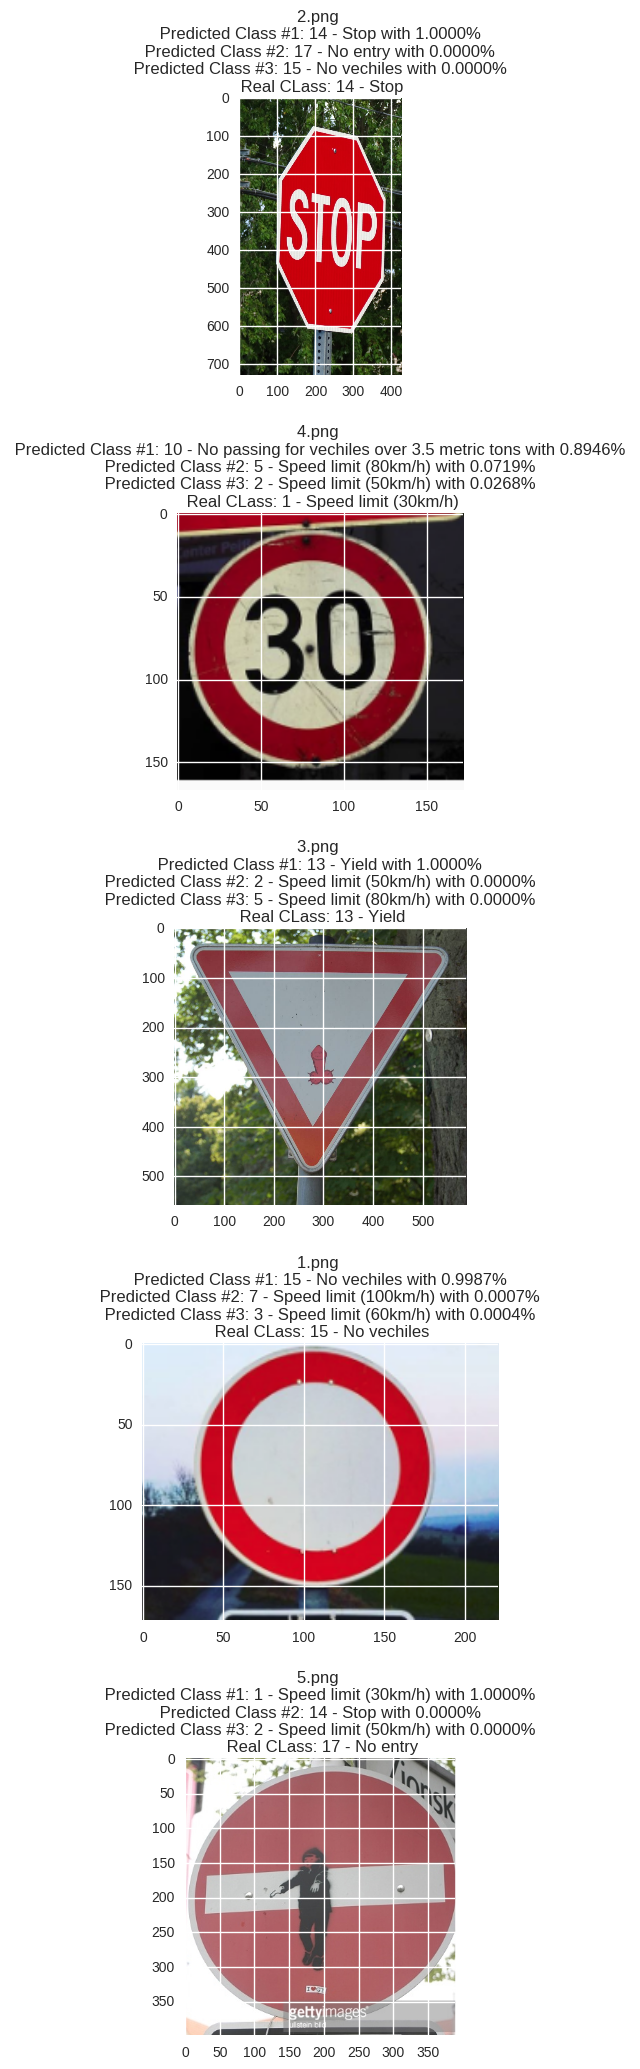

In [41]:
f, ax = plt.subplots(num_images, 1, figsize=(12.0, 25.0))
#f.suptitle("{} - {}.".format(classId, sign_names['SignName'][classId]), fontsize='x-large') 
f.subplots_adjust(hspace=.5)
for i, filename in enumerate(os.listdir(path)):    
    #Load Image from file
    img = plt.imread(path+filename)
    
    #Plot original Image
    ax[i].imshow(img)
    ax[i].set_title("{} \n Predicted Class #1: {} - {} with {:.4f}% \n Predicted Class #2: {} - {} with {:.4f}% \n Predicted Class #3: {} - {} with {:.4f}% \n Real CLass: {} - {}".format(
            filename, 
            top_k_indices[i][0], sign_names['SignName'][top_k_indices[i][0]], top_k_values[i][0],
            top_k_indices[i][1], sign_names['SignName'][top_k_indices[i][1]], top_k_values[i][1],
            top_k_indices[i][2], sign_names['SignName'][top_k_indices[i][2]], top_k_values[i][2],
            inet_real_y[i], sign_names['SignName'][inet_real_y[i]]))
 
plt.plot()